# Objectifs du projet

Fruits! est une jeune start-up appartenant au secteur l'AgriTech qui souhaite proposer de nouvelles façons de récolter les fruits. Son ambition est de préserver la biodiversité fruitière en développant des robots cueilleurs intelligents, capables d’adapter leurs modes de traitement à chaque espèce, afin de garantir une récolte plus respectueuse et optimisée. 

Dans une première étape, la start-up souhaite accroître sa visibilité auprès du grand public en lançant une application mobile interactive. Cette application offrira aux utilisateurs la possibilité de photographier un fruit et de recevoir immédiatement des informations détaillées à son sujet, telles que son espèce, ses caractéristiques et son origine. Pour la start-up, cette application permettra de sensibiliser le grand public à la biodiversité des fruits et de développer et tester une première version d'un moteur de classification des images de fruits. 

Pour répondre à cette objectif, une première chaine de traitement comprenant le préprocessing, l une étape d'extraction de caractéristiques et une étape de réduction de dimension a été mise en place. De plus, pour anticiper une croissance rapide du volume de données prévue par la start-up une fois l’application déployée, une solution évolutive et distribuable a été utilisé. Le code a été développé et exécuté en local, en utilisant un échantillon réduit d'images et ce premier test a permis de valider la chaine de traitement développée ainsi que la solution choisie pour assurer la gestion du traitement de données massive et l'augmentation future d'une volume de ces données.

Les prochaines étapes consisteront donc à déployer la chaîne de traitement dans un environnement Big Data afin d’exploiter les capacités du calcul distribué pour executer les traitement à plus grande échelle.

# Sommaire

- [1 Objectifs du projet](#Objectifs-du-projet)
- [2 Sommaire](#Sommaire)
- [3 Import](#Import-des-librairies)
- [4 Initialisation de l’environnement PySpark sur le cloud](#Initialisation-de-l’environnement-PySpark-sur-le-cloud)
- [5 Définition des PATH pour charger les images et enregistrer les résultats](#Définition-des-PATH-pour-charger-les-images-et-enregistrer-les-résultats)
- [6 Chargement des données](#Chargement-des-données)
- [7 Préparation du modèle](#Préparation-du-modèle)
- [8 Extraction des caractéristiques](#Extraction-des-caractéristiques)
- [9 Réduction de la dimensionnalité des vecteurs de caractéristiques](#Réduction-de-la-dimensionnalité-des-vecteurs-de-caractéristiques)
- [10 Conclusions](#Conclusions)

# Initialisation de l’environnement PySpark sur le cloud

Afin d'anticiper l'augmentation rapide du volume de données prévus après la livraison du projet, les scripts ont été développés en PySpark. L’objectif était de concevoir une solution scalable et capable de passer d’un traitement local à un traitement distribué sur un cluster.

L'outil PySpark correspond à la version Python du moteur Apache Spark, un framework open source de calcul distribué en mémoire, conçu pour le traitement et l’analyse de données massives. Concrètement, Spark permet de répartir l’exécution d’un même programme sur plusieurs machines, en coordonnant les calculs et les échanges de données de manière optimisée.

Le fonctionnement de Spark repose sur deux éléments principaux :
- Le driver qui orchestre le traitement, planifie les tâches et distribue leur exécution sur les différents noeuds.
- Le cluster manager qui alloue les ressource nécessaire à l'execution du programme.
- Les exécuteurs, qui sont des processus indépendants responsables de l’exécution concrète des tâches. Chacun dispose de ressources configurables (CPU, mémoire) et traite un fragment des données en parallèle.

Dans ce projet, Spark a donc été utilisé dans les deux environnements :
- Dans un environnement local, pour simuler le calcul distribué et valider la chaîne de traitement sur un échantillon réduit de données.
- Sur le cloud, pour exécuter le pipeline sur un cluster réel, exploitant pleinement les capacités du calcul distribué.

## Environnement de travail

Dans cette partie où les traitements vont être effectués à plus grande échelle sur un volume plus conséquent de données, l'environnement de travail est un environnement BigData qui a été configuré sur AWS. 

Le coeur de cette architecture repose sur le service Elastic MapReduce (EMR) d'AWS qui permet de lancer et de gérer facilement des cluster Spark. Ces clusters EMR permettent d'orchestrer les traitements a effectuer en parallèles et sont constitués d'instance provenant du service Elastic Compute Cloud (EC2). Ces instance EC2 sont de différents types selon leur rôle au sein du cluster. En particulier, le cluster doit être consitué d'une instance EC2 primaire qui permettra d'héberger le driver programme et le cluster manager, et de plusieurs instance EC2 principales qui correspondront aux executeurs qui vont effectuer les traitements a réaliser en parallèles. Pour pouvoir stocker les données de facon permanente et sécurisé, cet environnement inclu également le simple storage service (S3) d'AWS. Ce service a donc été utilisé pour conserver à la fois les images des fruits à traiter, le notebook contenant le code ainsi que les résultats obtenus. 

# Initialisation de la session Spark

In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
9,application_1765791054156_0010,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,application_1765791054156_0007,pyspark,idle,Link,Link,
7,application_1765791054156_0008,pyspark,idle,Link,Link,
9,application_1765791054156_0010,pyspark,idle,Link,Link,✔


# Import des librairies

Les packages nécessaires ont été installés via l'étape de bootstrap lors de l'instanciation du serveur.

In [3]:
# Librairies standard
import io
import os
import boto3

# Manipulation de données
import pandas as pd
import numpy as np

# Images
from PIL import Image

# Visualisation
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# PySpark 
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA, VectorAssembler, StandardScaler
from pyspark.ml.functions import vector_to_array
from pyspark.sql import functions as F
from pyspark.sql import functions
from pyspark.sql.functions import udf, col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, FloatType, DoubleType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Définition des PATH pour charger les images et enregistrer les résultats

Afin de mieux gérer les différents import de données et export de résultat, on va commencer par définir les paths qui seront utilisés. Pour commencer, on récupère le répertoire courant du script avec os.getcwd() puis on identifie le dossier parent grâce à os.path.dirname() ce qui permettra de construire les chemins vers les sous-dossiers de données et de résultats : Test_Local, qui contient les images qui seront traitées dans cet environnement local, et Results, destiné à stocker les résultats du traitement.

In [4]:
# Répertoire du bucket Amazon S3
PATH = 's3://mon-bucket-oc-p9'

# Chemins vers les sous-dossiers "data" et "Output" situés dans le dossier parent
PATH_Data = PATH+'/Data/Cloud_sample'
PATH_Result_features_pq = PATH+'/Output/Cloud_sample/Features'
PATH_Result_PCA_pq = PATH+'/Output/Cloud_sample/PCA'
PATH_Result_PCA_csv = PATH+'/Output/Cloud_sample/PCA'
PATH_Result_projection = PATH+'/Output/Cloud_sample/Projections'

# Affichage des chemins des dossiers
print(f"PATH:                      {PATH}")
print(f"PATH_Data:                 {PATH_Data}")
print(f"PATH_Result_features_pq:   {PATH_Result_features_pq}")
print(f"PATH_Result_PCA_pq:        {PATH_Result_PCA_pq}")
print(f"PATH_Result_PCA_csv:       {PATH_Result_PCA_csv}")
print(f"Path_Result_projection:    {PATH_Result_projection}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:                      s3://mon-bucket-oc-p9
PATH_Data:                 s3://mon-bucket-oc-p9/Data/Cloud_sample
PATH_Result_features_pq:   s3://mon-bucket-oc-p9/Output/Cloud_sample/Features
PATH_Result_PCA_pq:        s3://mon-bucket-oc-p9/Output/Cloud_sample/PCA
PATH_Result_PCA_csv:       s3://mon-bucket-oc-p9/Output/Cloud_sample/PCA
Path_Result_projection:    s3://mon-bucket-oc-p9/Output/Cloud_sample/Projections

# Chargement des données

Les images ont dans un premier temps, été importées au format binaire, un format qui offre une plus grande flexibilité pour le prétraitement. Lors de l'import, une option a été utilisée pour choisir le format des images que l'on souhaiter charger, ainsi seul les fichiers du format spécifié ont été pris en compte et on ne chargera que les images de ce format. Une autre option a permis de charger tous les objets présents dans les sous-dossiers du répertoire indiqué sont, ce qui a facilité le traitement récurcif de l’ensemble de la structure de données et la centralisation toutes les images disponibles pour l’étape suivante de traitement.

In [5]:
# Chargement des images
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

# Affichage des 5 premières images
images.show(5)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://mon-bucket-o...|2025-12-02 14:02:55|  7353|[FF D8 FF E0 00 1...|
|s3://mon-bucket-o...|2025-12-02 14:02:55|  7350|[FF D8 FF E0 00 1...|
|s3://mon-bucket-o...|2025-12-02 14:02:55|  7349|[FF D8 FF E0 00 1...|
|s3://mon-bucket-o...|2025-12-02 14:02:55|  7348|[FF D8 FF E0 00 1...|
|s3://mon-bucket-o...|2025-12-02 14:03:03|  7328|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

In [6]:
# Ajout d'une colonne correspondant au label des images
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))

# Affichage de 
print(images.printSchema())

# Affichage des 5 premières images
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------------------+----------+
|path                                                                       |label     |
+---------------------------------------------------------------------------+----------+
|s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_cloud/Watermelon/r_106_100.jpg|Watermelon|
|s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_cloud/Watermelon/r_109_100.jpg|Watermelon|
|s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_cloud/Watermelon/r_108_100.jpg|Watermelon|
|s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_cloud/Watermelon/r_107_100.jpg|Watermelon|
|s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_cloud/Watermelon/r_95_100.jpg |Watermelon|
+---------------------------------------------------------------------------+-

Le tableau contient l’ensemble des images chargées, avec pour chacune son chemin d’accès (path) associé, la date et l’heure de sa dernière modification, sa longueur ainsi que son contenu. Cette structure garantie une bonne tracabilité des fichiers : elle permet de conserver une référence claire vers l’emplacement original de chaque image, de vérifier leur date de mise à jour, et de garantir la cohérence entre les données brutes et leurs traitements ultérieurs.

# Préparation du modèle

Dans ce projet, les images ont été prétraitées pour qu'un modèle extrait leur caractéristique dont la dimensionnalité a ensuite été réduite. Il n'était pas à ce stade nécessaire d'entrainer un modèle. Pour cela, la technique de transfert learning a été utilisée, consistant à exploiter les connaissances d’un modèle préentraîné, ici MobileNetV2, et à les adapter à la problématique spécifique du projet.

## Chargement et préparation du modèle MobileNetV2

Le modèle a dans un premier temps été chargé et configuré pour recevoir les images avec une dimension de 224×224×3. Dans l'étape suivante, le modèle a été adapté pour la tâche d'extraction de caractéristiques. Pour cela, la dernière couche softmax, qui réalise la classification selon les 1000 catégories d'ImageNet, n’est pas utilisée, car l’objectif ici est uniquement d’extraire les caractéristiques. Cette étape permet de récupérer la sortie de l’avant-dernière couche et d'obtenir un vecteur de caractéristiques de dimension (1,1,1280). 

Dans ce projet, le modèle selectionné correspond à MobileNetV2, un modèle caractérisé par une execution rapide et une dimensionnalité de son vecteur de caractéristique relativement faible. 

Le modèle a donc été chargé avec les poids précalculés sur ImageNet, puis un nouveau modèle a été créé en conservant l’entrée initiale et en définissant la sortie sur l’avant-dernière couche pour permettre l’extraction des features.

In [7]:
# Chargement du modèle 
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Définition du nouveau modèle
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

# Affichage de l'architecture du modèle
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

L'affichage du résumé du nouveau modèle permet de constaster que la sortie récupérée en sortie correspond bien à un vecteur de dimension (1,1,1280)

Comme les calculs sont ici exécutés de manière distribuée, il est important que tous les workers puissent accéder au modèle et à ses poids. Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser les poids aux différents workers, afin de garantir que chaque worker utilise exactement le même modèle pour l’extraction des caractéristiques et que les résultats soient cohérents à travers l’ensemble du cluster.

In [9]:
# Diffusion des poids au workeurs
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Fonction pour charger le modèle et diffuser ses poids aux workers

In [10]:
def model_fn():
    
    """
    Crée un modèle MobileNetV2 avec les poids fournis par pyspark et gèle toutes les 
    couches existantes sauf la dernière couche avant la sortie.

    Cette fonction permet d'utiliser MobileNetV2 comme extracteur de  caractéristiques 
    dans un contexte de transfert de connaissances tout en initialisant le modèle avec 
    des poids partagés via Spark Broadcast.

    Paramètres
        - broadcast_weights (pyspark.Broadcast): Objet broadcast contenant les poids à utiliser pour initialiser le modèle.

    Sortie
        - tensorflow.keras.Model: Nouveau modèle Keras avec les couches gelées et les poids initialisés.
    """
        
    # Création du modèle MobileNetV2 sans poids pré-entraînés
    model = MobileNetV2(weights=None,
                        include_top=True,
                        input_shape=(224, 224, 3))
    
    # Gel des couches pour empêcher leur entraînement
    for layer in model.layers:
        layer.trainable = False
        
    # Création d'un nouveau modèle dont la sortie est l'avant-dernière couche
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    
    # Chargement des poids diffusés depuis le driver vers tous les exécuteurs
    new_model.set_weights(brodcast_weights.value)
    
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Extraction des caractéristiques

Pour pouvoir extraire les caractéristiques des images de manière efficace, plusieurs étapes ont été suivies. Dans un premier temps, les images brutes ont été prétraitées afin de les rendre compatibles avec le modèle MobileNetV2 (ouverture, redimensionnement, conversion en tableau numérique puis normalisation). Ensuite, le modèle a été appliqué aux images prétraitées pour générer des vecteurs numériques de features représentant les informations visuelles de chaque image.

## Fonction utilisées

Pour cela, deux fonctions ont été définies : 
- La première fonction a permis de prétraiter les images
- La seconde fonction a permis d'appliquer le modèle à une série d’images pour extraire leur caractéristiques.

Pour tirer partie du calcul distribué offert par l'environnement PySpark, la fonction d'extraction de caractéristiques a été définie comme une Pandas UDF avec le décorateur @pandas_udf('array<float>', PandasUDFType.SCALAR_ITER) ce qui a permis à Spark de traiter les images par lots (batches) sous forme de séries Pandas et donc d'accélérer la vitesse de traitement des images.

In [11]:
def preprocess(content):
    """
    Prétraite le contenu brut d'une image pour le rendre compatible avec MobileNetV2.

    Étapes réalisées :
    1. Ouvre l'image à partir des octets bruts (bytes) fournis.
    2. Redimensionne l'image à 224x224 pixels (dimension attendue par MobileNetV2)
    3. Convertit l'image en un tableau NumPy à 3 dimensions (hauteur, largeur, canaux).
    4. Applique la fonction de prétraitement de MobileNetV2 (normalisation spécifique).

    Paramètres
        -content (bytes): Contenu brut de l'image (fichier image lu en binaire).

    Sortie
        - np.ndarray: Tableau NumPy prétraité et prêt à être utilisé comme entrée du modèle.
    """
    
    # Ouverture de l'image à partir des bytes et redimensionnement
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    
    # Conversion de l'image en tableau NumPy
    arr = img_to_array(img)
    
    # Application du prétraitement spécifique à MobileNetV2 et sortie du tableau
    return preprocess_input(arr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
    Scalar Iterator pandas UDF pour prétraiter les images et extraire les features
    avec MobileNetV2 dans un contexte Spark distribué.
    
    Paramètres
        - Itérateur sur des batches de données, chaque batch
          étant une pandas Series contenant des images brutes.
    
    Sortie 
        - Series Spark contenant les vecteurs de features pour chaque image.
    """
    
    # Chargement du modèle sur le worker
    model = model_fn()
    
    for content_series in content_series_iter:
        
        # Prétraitement des images : ouverture, redimensionnement, conversion en array et normalisation
        input_array = np.stack(content_series.map(lambda content: preprocess(content)))
        
        # Extraction des features avec le modèle
        preds = model.predict(input_array)
        
        # Aplatissement des tenseurs multi-dimensionnels pour stockage facile dans Spark
        features = [p.flatten() for p in preds]
        
        yield pd.Series(features)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

##  Exécution des actions d'extraction de features

Dans cette étape, la fonction permettant d'extraire les caractéristiques des images est appliquées aux données. Pour que ces traitements soit effectués de façon distribuée, on a utilisé la méthode images.repartition(20) ce qui a permis de redistribuer les données sur 20 partitions dans le cluster Spark. Cela a ainsi permis à Spark de paralléliser le traitement des images sur plusieurs noeuds ou coeur, ce qui a accéléré considérablement le calcul des features. Cette méthode est donc particulièrement utile dans cette partie où les traitements sont effectués à plus grande échelle sur le cloud.

Une fois les features extraites, les résultats sont sauvegardés au format Parquet qui permet un stockage efficace, un accès rapide aux colonnes et une compression automatique des données pour économiser de l’espace. De plus ce format est compatible avec Spark et d'autres outil BigData.

In [13]:
# Extraction des features des images de la dataframe
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            col("content"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Enregistrement des données au format parquet
features_df.write.mode("overwrite").parquet(PATH_Result_features_pq)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##  Chargement des données enregistrées et validation du résultat


In [15]:
# CHargement des données
df_spark = spark.read.parquet(PATH_Result_features_pq, engine='pyarrow')

# Conversion en pandas
df = df_spark.toPandas()

# Conversion de la variable feature
df['features'] = df['features'].apply(np.array)

# Affichage des 5 premières lignes
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                           features
0  s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_c...  ...  [0.012825525365769863, 0.47010111808776855, 0....
1  s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_c...  ...  [0.19319137930870056, 0.02246147207915783, 0.0...
2  s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_c...  ...  [0.28973183035850525, 0.6997952461242676, 0.01...
3  s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_c...  ...  [0.714703381061554, 0.14000152051448822, 0.0, ...
4  s3://mon-bucket-oc-p9/Data/Cloud_sample/Test_c...  ...  [0.0639929473400116, 1.0848349332809448, 0.022...

[5 rows x 4 columns]

On peut maintenant vérifier le format des caractéristiques extraites par le modèle à l’étape précédente. Celles-ci sont stockées sous forme de liste dans la dernière variable de la dataframe. Il faut donc extraire cette liste afin d’en analyser le format.

In [16]:
# Affichage de la dimension du vecteur de caractéristiques 
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [17]:
# Affichage de la forme de la dataframe
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(4929, 4)

# Réduction de la dimensionnalité des vecteurs de caractéristiques

Dans cette étape, les vecteurs de features extraits précédemment sont préparés pour la réduction de dimension. Tout d’abord, une UDF Spark est définie pour convertir les tableaux de features en vecteurs Spark (Vectors.dense), puis appliquée pour créer une nouvelle colonne features_vec. Ensuite, une PCA est initialisée pour réduire la dimensionnalité à 100 composantes principales, et le modèle PCA est appliqué sur les données pour produire la colonne features_pca contenant les différentes composantes construites.

Pour faciliter l’exploitation des données hors de Spark, une deuxième UDF est utilisée pour convertir les vecteurs Spark PCA en deux composantes, créant ainsi une nouvelle colonne pour chacune des deux premières composantes principales construites lors de la PCA. Les colonnes nécessaires (PC1, PC2 et label) sont ensuite extraites et converties en Dataframe Pandas puis en tableaux Numpy : X_pca contient alors les deux premières composantes principales, et y les labels correspondants. Cette préparation permet d’avoir un format plus simple à utiliser pour les étapes suivantes d’analyse et notamment pour la projection des images dans un espace en deux dimensions.

## PCA

In [18]:
# Définition d'une udf pour converir le tableau de features en vecteur Spark
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Application de l'UDF pour créer une nouvelle colonne features_vec
features_vector_df = features_df.withColumn("features_vec", array_to_vector_udf("features"))

# Initialisation du scaler
scaler = StandardScaler(
    inputCol="features_vec",
    outputCol="feature_scaled",
    withMean=True,
    withStd=True)

# Initialisation de la PCA
pca = PCA(k=100, inputCol="features_vec", outputCol  = "features_pca")

# Création du pipeline
pipeline = Pipeline(stages=[scaler, pca])

# Reduction de la dimension avec la PCA
pipeline_model = pipeline.fit(features_vector_df)
features_pca_df = pipeline_model.transform(features_vector_df)

# Sauuvegarde
features_pca_df.write.mode("overwrite").parquet(PATH_Result_PCA_pq)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Nom du bucket et du chemin cible sur S3
bucket_name = "mon-bucket-oc-p9"
object_key = "Output/Cloud_sample/PCA/Results_PCA.csv"

# Conversion de la colonne features PCA de vecteur en array
features_pca_df_array = features_pca_df.withColumn(
    "pca_array",
    vector_to_array("features_pca")
)

# Création des colonnes PC1 à PCn
df_pca_finale = features_pca_df_array.select(
    "path",
    "label",
    *[F.col("pca_array")[i].alias(f"PC{i+1}") for i in range(pca.getK())]
)

# Conversion en pandas
df_pandas = df_pca_finale.toPandas()

# Création d'un buffer memoire
buf = io.StringIO()
df_pandas.to_csv(buf, index=False)
buf.seek(0)

# Envoie de la dataframe vers s3
s3 = boto3.client('s3')
s3.put_object(Bucket=bucket_name, Key = object_key, Body = buf.getvalue())

# Libéreration de la mémoire
buf.close()

# Affichage du chemin de sauvegarde
print(f"Dataframe enregistrée sur s3://{bucket_name}/{object_key}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Dataframe enregistrée sur s3://mon-bucket-oc-p9/Output/Cloud_sample/PCA/Results_PCA.csv
/usr/local/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)

## Projections des données

In [20]:
# Définition d'UDFs pour extraire les deux premières composantes principales
pc1_udf = udf(lambda v: float(v[0]), FloatType())
pc2_udf = udf(lambda v: float(v[1]), FloatType())

# Application des UDFs pour créer de nouvelles colonnes PC1 et PC2
features_pca_2d_df_spark = features_pca_df.withColumn("PC1", pc1_udf("features_pca")) \
                                 .withColumn("PC2", pc2_udf("features_pca"))

# Sélection des colonnes nécessaires pour l'affichage et conversion en Pandas
features_pca_2d_df_pandas = features_pca_2d_df_spark.select("PC1", "PC2", "label").toPandas()

# Conversion explicite des listes de features en tableau numpy
X_pca = features_pca_2d_df_pandas[["PC1", "PC2"]].to_numpy()

# Extraction des labels sous forme de vecteur numpy
y = features_pca_2d_df_pandas['label'].values

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

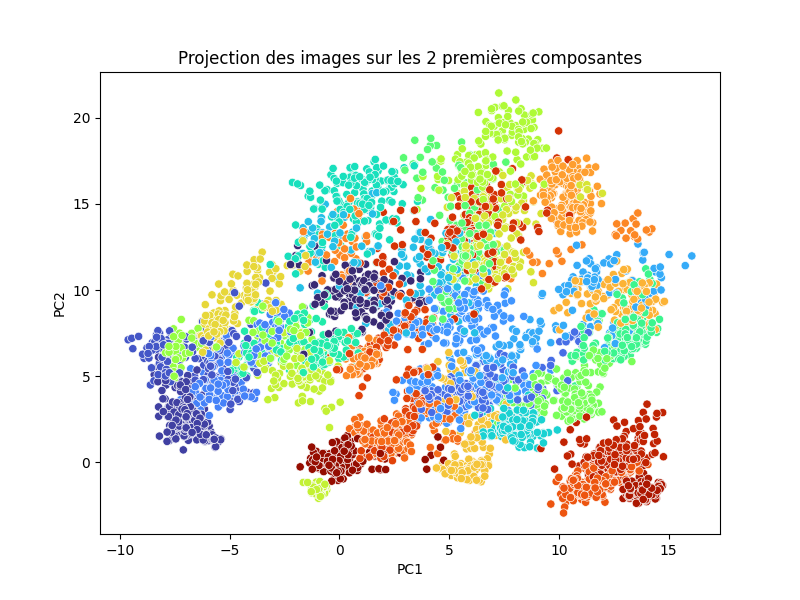

In [21]:
# Initialisation du graphique
plt.figure(figsize=(8,6))

# Définition de la palette de couleur à utiliser
palette = sns.color_palette('turbo', 30)

# Construction du scatterplot
sns.scatterplot(x=X_pca[:, 0], y =X_pca[:, 1], hue=y, palette=palette, legend=False)

# Ajout d'un label sur x et y
plt.xlabel("PC1")
plt.ylabel("PC2")

# Ajout d'un titre
plt.title("Projection des images sur les 2 premières composantes")

# Récupération des limites des axes
xlim = plt.xlim()
ylim = plt.ylim()

# Sauvegarde du plot dans une variable
plot1=plt

# Affichage du plot
%matplot plt

La projection des 4929 images de fruits traitées sur le cloud montre que les images ont tendance à se regrouper selon les différentes espèces présentes dans le jeu de données. Cette organisation suggère que les caractéristiques extraites par le modèle permettent de capturer des éléments discriminants entre espèces. Toutefois, compte tenu du nombre important d’images  d'espèces représentées, les différents amas se chevauchent partiellement et les couleurs propres à chaque espèces sont tres proches les unues des autres ce qui complexifie l'interprétation des résultats obtenus. 

Afin de mieux visualiser la structure globale des données et d’atténuer la complexité liée à la densité des points, une seconde représentation a été réalisée. Celle-ci ne repose plus sur l’ensemble des images, mais sur les centroïdes correspondant à chaque espèce. Cette seconde approche permettra de mettre en évidence la position moyenne de chaque espèces de fruits dans l’espace composé par les deux première composantes et permettra ainsi d’observer plus clairement les relations de proximité ou de séparation entre les différentes espèces de fruits.

In [22]:
# Nom du bucket et du chemin cible sur S3
bucket_name = "mon-bucket-oc-p9"
object_key = "Output/Cloud_sample/Projections/pca_projection_point.png"

# Création d'un buffer memoire
buf = io.BytesIO()
plot1.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)

# Envoie de la figure vers s3
s3 = boto3.client('s3')
s3.upload_fileobj(buf, bucket_name, object_key)

# Libéreration de la mémoire
buf.close()

# Affichage du chemin de sauvegarde
print(f"Figure enregistrée sur s3://{bucket_name}/{object_key}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Figure enregistrée sur s3://mon-bucket-oc-p9/Output/Cloud_sample/Projections/pca_projection_point.png
/usr/local/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)

In [23]:
# Calcul du centroïde par label
centroids_df = features_pca_2d_df_spark.groupBy("label").agg(
    functions.avg("PC1").alias("x_centroid"),
    functions.avg("PC2").alias("y_centroid")
)

# Extraction de la première image par label
window = Window.partitionBy("label").orderBy("path")
first_images_df = features_pca_df.withColumn("rn", functions.row_number().over(window)) \
    .filter(functions.col("rn") == 1) \
    .select("label", "path", "content")

# Jointure des centroïdes et des images
centroids_with_path = centroids_df.join(first_images_df, on="label").collect()

# Création d'un dictionnaire label -> (centroïde, image_path)
centroids = {
    row['label']: (np.array([row['x_centroid'], row['y_centroid']]), row['content'])
    for row in centroids_with_path
}


def get_image(path, zoom=0.2):
    """
    Charge une image depuis un chemin de fichier et retourne un objet OffsetImage
    utilisable pour l'affichage (par exemple dans une projection PCA).

    Paramètres
     - path (str): Chemin vers l'image. Peut contenir le préfixe ``"file:"``.
     - zoom (float, optional (default=0.2)): Facteur de zoom appliqué à l'image lors de l'affichage.

    Sortie
     - matplotlib.offsetbox.OffsetImage:: Objet OffsetImage contenant l'image chargée, prêt à être utilisé
     dans une annotation ou un graphique matplotlib.
    """
    
    # ouverture de l'image
    img = Image.open(io.BytesIO(content))  
    
    return OffsetImage(img, zoom=zoom)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

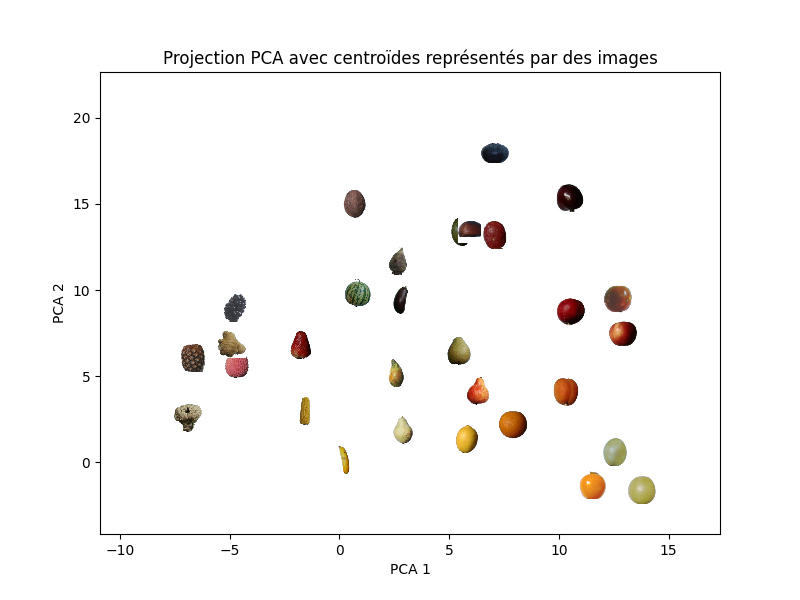

In [24]:
# Initialisation de la figure
fig, ax = plt.subplots(figsize=(8,6))

# tracer les centroïdes comme points
for label, (centroid, path) in centroids.items():
    ax.scatter(centroid[0], centroid[1], color='red', s=50)  

# puis ajouter les images
for label, (coords, content) in centroids.items():
    ab = AnnotationBbox(get_image(content), coords, frameon=False)
    ax.add_artist(ab)

# Application des mêmes limites sur x et y que pour le premier plot
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Ajout d'un titre à l'axe des x
ax.set_xlabel("PCA 1")

# AJout d'un titre à l'axe des y
ax.set_ylabel("PCA 2")

# AJout d'un titre
ax.set_title("Projection PCA avec centroïdes représentés par des images")

# Sauvegarde du plot dans une variable
plot2 = plt

# Affichage du plot
%matplot plt

In [25]:
# Nom du bucket et du chemin cible sur S3
bucket_name = "mon-bucket-oc-p9"
object_key = "Output/Cloud_sample/Projections/pca_projection_centroïdes.png"

# Création d'un buffer memoire
buf = io.BytesIO()
plot2.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)

# Envoie de la figure vers s3
s3 = boto3.client('s3')
s3.upload_fileobj(buf, bucket_name, object_key)

# Libéreration de la mémoire
buf.close()

# Affichage du chemin de sauvegarde
print(f"Figure enregistrée sur s3://{bucket_name}/{object_key}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Figure enregistrée sur s3://mon-bucket-oc-p9/Output/Cloud_sample/Projections/pca_projection_centroïdes.png

Ce second graphique représentant les centroïdes calculés pour chaque espèce de fruit permet de mieux visualier la structure générale des données. On observe notamment, que les espèces de fruits partageant des caractéristiques visuelles similaires (couleurs/formes/textures) apparaissent plus proches les unes des autres dans l'espace défini par les deux premières composantes de la PCA. 

Ainsi, les trois espèces correspondant à des poires se situent à proximité, ce qui traduit la cohérence de leurs caractéristiques morphologiques qui ont été extraites par le modèle. De manière plus générale, les espèces semblent s’organiser selon des gradients liés à la couleur et à la texture. Notamment, les fruits possédant une enveloppe rugueuse, comme l’ananas ou le litchi, se regroupent plutôt vers la gauche du graphique, tandis que les fruits de couleur jaunes apparaissent globalement plus proches les uns des autres que des fruits présentant une autre couleur.

# Conclusions

Le projet s’est déroulé en deux phases complémentaires, en tenant compte des contraintes imposées.

Dans un premier temps, la solution a été développée et testée en local sur une machine virtuelle Ubuntu. Cette phase a permis d’installer et configurer Spark pour simuler un environnement de calcul distribué, en utilisant chaque coeur de processeur comme un worker indépendant. Le traitement a été réalisé sur un jeu de données réduit afin de valider le bon fonctionnement de la solution. Le transfert learning a été effectué à partir du modèle MobileNetV2, choisi pour sa légèreté et sa rapidité puis le vecteur de caractéristique extrait par le modèle a été réduit à l'aide d'une PCA. Les résultats ont été enregistrés en format Parquet. Toutes ces étapes se sont déroulées sans aucun problèmes, démontrant la faisabilité de la solution en local.

La deuxième phase a consisté à déployer la solution sur un cluster de calcul réel pour anticiper une augmentation future du volume de données. Pour cela, Amazon Web Services (AWS) a été utilisé afin de bénéficier d’une puissance de calcul à la demande, avec un coût maîtrisé. Le service EMR d'AWS a permis de créer un cluster complet avec Spark, Hadoop, JupyterHub et TensorFlow déjà installés et configurés, assurant une mise en place rapide, fiable et évolutive, et facilitant l’installation des librairies sur l’ensemble des machines du cluster.

Le notebook a été exécuté de manière identique à la phase locale, cette fois sur un échantillon plus conséquent d'images du dossier “Test”. Les données ont été stockées sur Amazon S3, un service offrant un espace quasi illimité et un accès sécurisé, tout en conservant des coûts proportionnels à l’usage. L'execution des traitements à plus grande échelle dans l'environnement BigData a confirmé le bon déroulement de la solution sur le cloud. La projection des données dans un espace formé par les deux premières composantes principales a montré que les caractéristiques étaient suffisament discriminantes pour séparer les images de fruits en fonction de leur espèces.

L'environnement mis en place permet désormais d’adapter facilement la puissance de calcul en fonction de la charge, soit en ajoutant des machines au cluster, soit en augmentant la capacité des instances existantes, avec des coûts toujours inférieurs à ceux liés à l’achat ou à la location de serveurs.